# Fall Detection — Cross-Placement Evaluation
**Compare CHEST / SHIRT / PANTS AutoGluon models**

---
Run **CHEST_mode → SHIRT_mode → PANTS_mode** notebooks first.
Each saves `models/<MODE>_results.csv` and `models/<MODE>_autogluon/`.

In [1]:
import os, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from autogluon.tabular import TabularPredictor
warnings.filterwarnings('ignore')

PLACEMENTS = ['CHEST', 'SHIRT', 'PANTS']
MODELS_DIR = 'models'
COLORS     = {'CHEST': '#2563eb', 'SHIRT': '#16a34a', 'PANTS': '#ea580c'}
os.makedirs(MODELS_DIR, exist_ok=True)
print('Evaluation notebook ready.')

Evaluation notebook ready.


/Users/frank/Vscode/Hardware-Project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Results CSVs

In [2]:
records = []
for p in PLACEMENTS:
    csv = os.path.join(MODELS_DIR, f'{p}_results.csv')
    if os.path.exists(csv):
        records.append(pd.read_csv(csv))
        print(f'OK  {p}')
    else:
        print(f'MISSING {p} — run {p}_mode.ipynb first')

if records:
    summary = pd.concat(records, ignore_index=True)
    cols = [c for c in ['placement','dataset','n_windows','n_features','test_f1','precision','recall','auc','best_model'] if c in summary.columns]
    print('\n=== Results Summary ===')
    print(summary[cols].to_string(index=False))

OK  CHEST
OK  SHIRT
OK  PANTS

=== Results Summary ===
placement                    dataset  n_windows  n_features  test_f1  precision   recall      auc          best_model
    CHEST                    SisFall      70346          23 0.868851   0.890611 0.848128 0.967994      ExtraTreesEntr
    SHIRT             FallAllD-Waist      30708          23 0.848507   0.841990 0.855126 0.975688 WeightedEnsemble_L2
    PANTS FallAllD-Waist (hip proxy)      30708          26 0.836028   0.867412 0.806835 0.970676      ExtraTreesGini


## 2. Metrics Comparison Chart

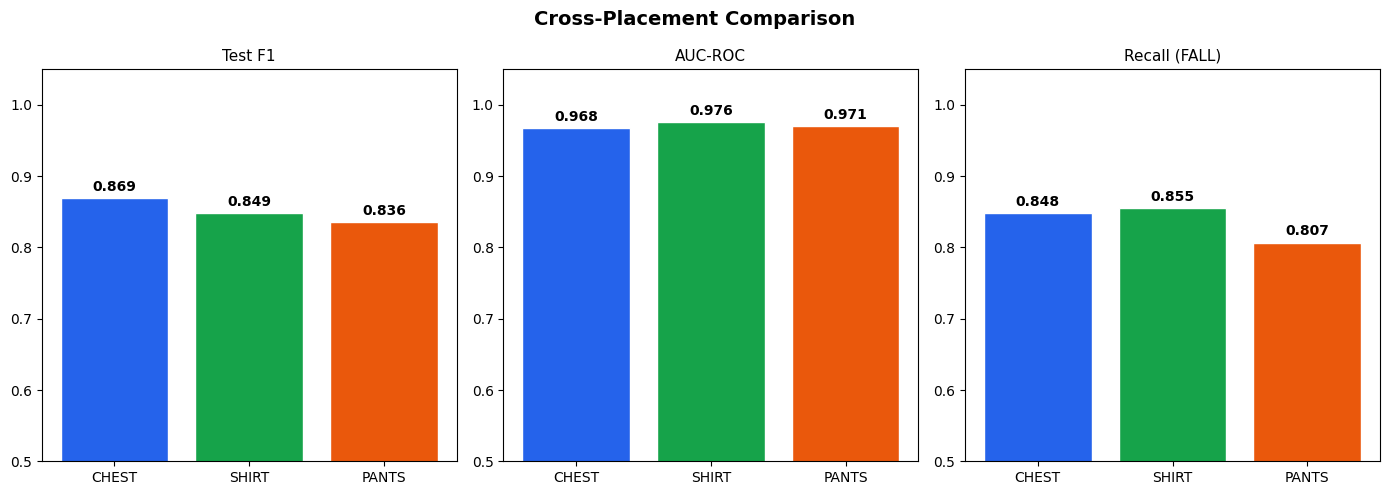

In [3]:
if records:
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    fig.suptitle('Cross-Placement Comparison', fontsize=14, fontweight='bold')
    for ax, col, title in zip(axes, ['test_f1','auc','recall'], ['Test F1','AUC-ROC','Recall (FALL)']):
        colors = [COLORS.get(p, 'gray') for p in summary['placement']]
        vals   = summary[col].astype(float)
        bars   = ax.bar(summary['placement'], vals, color=colors, edgecolor='white')
        ax.set_title(title, fontsize=11); ax.set_ylim(0.5, 1.05)
        for bar, v in zip(bars, vals):
            ax.text(bar.get_x()+bar.get_width()/2, v+0.01, f'{v:.3f}',
                    ha='center', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{MODELS_DIR}/eval_comparison.png', dpi=150)
    plt.show()

## 3. ROC Curves — Load Saved Models

In [4]:
# Shared feature extractors
def extract_23(window, fs=50):
    ax, ay, az = window[:,0], window[:,1], window[:,2]
    mag   = np.sqrt(ax**2+ay**2+az**2)
    mag_c = mag - np.mean(mag)
    freqs = fftfreq(len(mag), 1/fs)
    fmag  = np.abs(fft(mag))[:len(mag)//2]
    pf    = freqs[:len(mag)//2]
    jerk  = np.diff(mag)*fs
    f  = [float(np.mean(ax)),float(np.mean(ay)),float(np.mean(az))]
    f += [float(np.std(ax)), float(np.std(ay)), float(np.std(az))]
    f += [float(np.min(mag)),float(np.max(mag)),float(np.ptp(mag))]
    f += [float(np.sqrt(np.mean(ax**2))),float(np.sqrt(np.mean(ay**2))),float(np.sqrt(np.mean(az**2)))]
    f += [float(stats.skew(mag)),float(stats.kurtosis(mag))]
    f.append(float(np.sum(np.diff(np.sign(mag_c))!=0)))
    f.append(float(np.sum(np.abs(ax)+np.abs(ay)+np.abs(az))/len(ax)))
    f.append(float(pf[np.argmax(fmag)]) if len(fmag)>0 else 0.0)
    f.append(float(np.sum(fmag**2)))
    f.append(float(np.corrcoef(ax,ay)[0,1]) if np.std(ax)>0 and np.std(ay)>0 else 0.0)
    f.append(float(np.corrcoef(ay,az)[0,1]) if np.std(ay)>0 and np.std(az)>0 else 0.0)
    f.append(float(np.corrcoef(ax,az)[0,1]) if np.std(ax)>0 and np.std(az)>0 else 0.0)
    f.append(float(np.max(np.abs(jerk))) if len(jerk)>0 else 0.0)
    f.append(float(np.var(mag)))
    return np.array(f, dtype=np.float32)

FEAT23 = ['mean_ax','mean_ay','mean_az','std_ax','std_ay','std_az',
          'min_mag','max_mag','range_mag','rms_ax','rms_ay','rms_az',
          'skewness','kurtosis','zero_cross','SMA',
          'dom_freq','spectral_energy','corr_xy','corr_yz','corr_xz',
          'max_jerk','acc_variance']

def extract_26(window, fs=40):
    base = extract_23(window, fs)
    ax, ay, az = window[:,0], window[:,1], window[:,2]
    mag   = np.sqrt(ax**2+ay**2+az**2); mag_c = mag - np.mean(mag)
    freqs = fftfreq(len(mag),1/fs); fmag = np.abs(fft(mag))[:len(mag)//2]
    pf = freqs[:len(mag)//2]; gm = (pf>=0.5)&(pf<=3.0)
    sf = float(pf[gm][np.argmax(fmag[gm])]) if (gm.any() and len(fmag)==len(pf)) else 0.0
    ac = np.correlate(mag_c,mag_c,mode='full')[len(mag_c)-1:]; ac=ac/(ac[0]+1e-9)
    lmin,lmax=int(0.4*fs),int(1.2*fs)
    gr = float(ac[lmin:lmax].max()) if lmax<len(ac) else 0.0
    vs = float(np.std(az)/(np.std(ax)+np.std(ay)+1e-9))
    return np.concatenate([base,[sf,gr,vs]]).astype(np.float32)

FEAT26 = FEAT23+['step_freq','gait_regularity','vertical_symmetry']
EXTRACTOR = {'CHEST':(extract_23,FEAT23),'SHIRT':(extract_23,FEAT23),'PANTS':(extract_26,FEAT26)}
print('Extractors ready.')

Extractors ready.


In [5]:
# Quick synthetic test (seed 99 — unseen data)
rng = np.random.default_rng(99)
def make_test(n_fall=150, n_adl=300, win=100):
    wins, labs = [], []
    for _ in range(n_adl):
        t=np.arange(win)/50; ax=rng.normal(0,.5,win)+np.sin(2*np.pi*1.1*t)
        wins.append(np.stack([ax,rng.normal(0,.5,win),rng.normal(1,.3,win)],axis=1)); labs.append(0)
    for _ in range(n_fall):
        ax=np.concatenate([rng.normal(0,.1,25),rng.normal(2.5,.6,10),rng.normal(0,.2,65)])
        ay=np.concatenate([rng.normal(0,.1,25),rng.normal(1.8,.6,10),rng.normal(0,.2,65)])
        az=np.concatenate([rng.normal(.1,.2,25),rng.normal(3.0,.8,10),rng.normal(.2,.2,65)])
        wins.append(np.stack([ax,ay,az],axis=1)); labs.append(1)
    return wins, np.array(labs)
test_wins, y_true = make_test()
print(f'Shared test: {len(test_wins)} windows (Fall:{y_true.sum()}, ADL:{(y_true==0).sum()})')

Shared test: 450 windows (Fall:150, ADL:300)


In [6]:
model_res = {}
for p in PLACEMENTS:
    mpath = os.path.join(MODELS_DIR, f'{p}_autogluon')
    if not os.path.isdir(mpath):
        print(f'SKIP {p}: model not found'); continue
    extractor, feat_names = EXTRACTOR[p]
    pred = TabularPredictor.load(mpath, verbosity=0)
    X = pd.DataFrame([extractor(w) for w in test_wins], columns=feat_names)
    y_pred = pred.predict(X).values
    y_prob = pred.predict_proba(X)[1].values
    auc    = roc_auc_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    model_res[p] = dict(y_pred=y_pred, y_prob=y_prob, auc=auc, fpr=fpr, tpr=tpr)
    print(f'{p}: AUC={auc:.3f}')

CHEST: AUC=1.000
SHIRT: AUC=0.000
PANTS: AUC=0.521


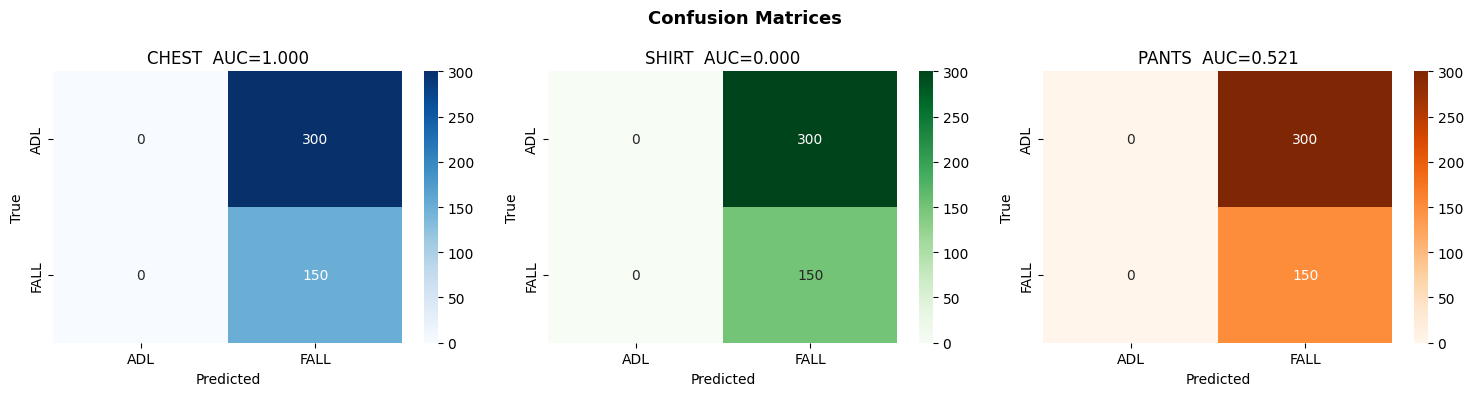

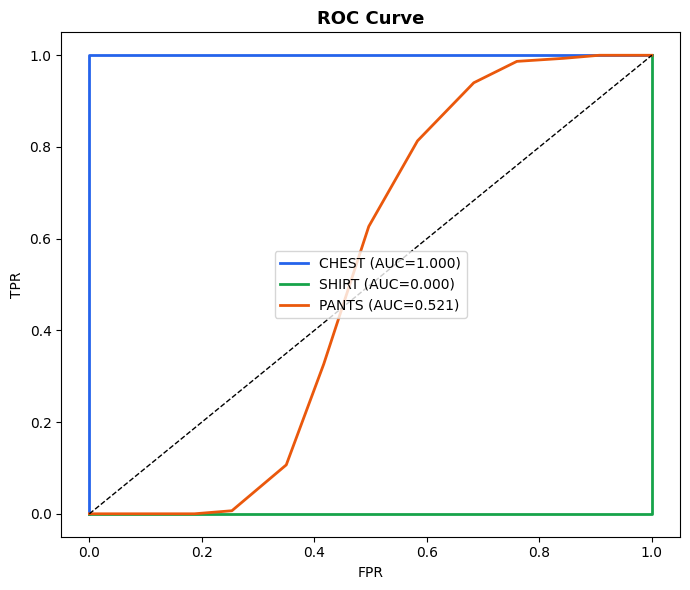

In [7]:
if model_res:
    # Confusion matrices
    fig, axes = plt.subplots(1, len(model_res), figsize=(5*len(model_res), 4))
    if len(model_res)==1: axes=[axes]
    cmaps={'CHEST':'Blues','SHIRT':'Greens','PANTS':'Oranges'}
    for ax, (p, res) in zip(axes, model_res.items()):
        cm = confusion_matrix(y_true, res['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps.get(p,'Blues'), ax=ax,
                    xticklabels=['ADL','FALL'], yticklabels=['ADL','FALL'])
        ax.set_title(f'{p}  AUC={res["auc"]:.3f}')
        ax.set_ylabel('True'); ax.set_xlabel('Predicted')
    plt.suptitle('Confusion Matrices', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{MODELS_DIR}/eval_confusion.png', dpi=150)
    plt.show()

    # ROC
    plt.figure(figsize=(7,6))
    for p, res in model_res.items():
        plt.plot(res['fpr'], res['tpr'], color=COLORS[p], lw=2,
                 label=f'{p} (AUC={res["auc"]:.3f})')
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('ROC Curve', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{MODELS_DIR}/eval_roc.png', dpi=150)
    plt.show()

## 4. Final Report

In [8]:
if records:
    print('=== FINAL EVALUATION REPORT ===')
    show = ['placement','dataset','n_windows','n_features','test_f1','precision','recall','auc','best_model']
    show = [c for c in show if c in summary.columns]
    print(summary[show].to_string(index=False))
    summary[show].to_csv(f'{MODELS_DIR}/final_report.csv', index=False)
    print(f'\nSaved: {MODELS_DIR}/final_report.csv')

print('\nFiles in models/:')
for fn in sorted(os.listdir(MODELS_DIR)) if os.path.exists(MODELS_DIR) else []:
    sz = os.path.getsize(os.path.join(MODELS_DIR,fn)) if os.path.isfile(os.path.join(MODELS_DIR,fn)) else 0
    print(f'  {fn:<45} {sz/1024:>7.1f} KB' if sz else f'  {fn}/')

=== FINAL EVALUATION REPORT ===
placement                    dataset  n_windows  n_features  test_f1  precision   recall      auc          best_model
    CHEST                    SisFall      70346          23 0.868851   0.890611 0.848128 0.967994      ExtraTreesEntr
    SHIRT             FallAllD-Waist      30708          23 0.848507   0.841990 0.855126 0.975688 WeightedEnsemble_L2
    PANTS FallAllD-Waist (hip proxy)      30708          26 0.836028   0.867412 0.806835 0.970676      ExtraTreesGini

Saved: models/final_report.csv

Files in models/:
  CHEST_autogluon/
  CHEST_confusion.png                              30.0 KB
  CHEST_importance.png                             42.5 KB
  CHEST_results.csv                                 0.2 KB
  CHEST_signal.png                                105.8 KB
  PANTS_autogluon/
  PANTS_confusion.png                              31.0 KB
  PANTS_results.csv                                 0.2 KB
  SHIRT_autogluon/
  SHIRT_confusion.png             